Author: William C Francis (willcf@sea.upen.edu)

###(a)

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random

#### Importing and Preprocessing data (Taking entire dataset)

In [ ]:
with open('book-war-and-peace.txt', 'r') as f:
     input_data = f.read()
input_data=input_data.replace("\n\n", " ")
input_data=input_data.replace("\n", " ") # Removing the \n newline characters from the data
n = 25 # Number of characters in a batch

while(len(input_data)%n!=0): # Making sure the number of characters are multiples of batch size n
  input_data = input_data+ ' '

batch_input = [input_data[i:i+n] for i in range(0, len(input_data), n)] # Splitting the text into batches of n
chars = set(''.join(batch_input))
int_to_ch = dict(enumerate(chars)) # Mapping integers to characters


ch_to_int = {char: ind for ind, char in int_to_ch.items()} #Mapping characters to integers
unique_n = len(ch_to_int)
batch_n = len(batch_input)
print("The number of unique characters is", unique_n)

The number of unique characters is 81


#### Splitting the data into input and target

In [ ]:
batched_input = []
batched_target = []

for i in range(batch_n):
    batched_input.append(batch_input[i])
    if(i == batch_n-1):
      batched_target.append(batch_input[i][1:] + ' ')
    else:
      batched_target.append(batch_input[i][1:] + batch_input[i+1][0]) # Target is one place shifted ahead from input

Mapping the data to integer and one-hot encoding them

In [ ]:
for i in range(batch_n): 
    batched_input[i] = [ch_to_int[ch] for ch in batched_input[i]] #Mapping the data from characters to integer
    batched_target[i] = [ch_to_int[ch] for ch in batched_target[i]]
len_in = n

def one_hot_encode(oneh_inp, unique_n, len_in, batch_n):
    oneh_out = np.zeros((batch_n, len_in, unique_n), dtype=np.float32) 
    for i in range(batch_n):
        for u in range(len_in):
            oneh_out[i, u, oneh_inp[i][u]] = 1
    return oneh_out

batched_input = one_hot_encode(batched_input, unique_n, len_in, batch_n)

###(b)

####Splitting the input and target to training and validation sets (80:20 Ratio)

In [ ]:
batched_input = torch.from_numpy(batched_input)
batched_target = torch.Tensor(batched_target)
val_size = int(len(batched_input) * 0.2) #Deciding split
input_train = batched_input[:-val_size,:,None,:]
target_train = batched_target[:-val_size,:,None]

input_val = batched_input[-val_size:,:,None,:]
target_val = batched_target[-val_size:,:,None]
print("The training input shape is ",input_train.shape)
print("The training target shape is ",target_train.shape)
print("The validation input shape is ",input_val.shape)
print("The validation target shape is ",target_val.shape)

The training input shape is  torch.Size([102088, 25, 1, 81])
The training target shape is  torch.Size([102088, 25, 1])
The validation input shape is  torch.Size([25521, 25, 1, 81])
The validation target shape is  torch.Size([25521, 25, 1])


#### Checking if GPU is available and changing device

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#### Model definition

In [ ]:
class Model(nn.Module):
    def __init__(self, inputshape, outputshape, hiddenshape, layers):
        super(Model, self).__init__()
        self.hiddenshape = hiddenshape
        self.layers = layers
        self.hidden = self.initialize_hidden(batch_n)
        self.rnn = nn.RNN(inputshape, hiddenshape, layers, nonlinearity = 'tanh', bias = True, batch_first=False)
        for name, param in self.rnn.named_parameters():
          if 'bias' in name:
            nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            nn.init.xavier_normal_(param)   # Xavier initialization of weights
        self.fc = nn.Linear(hiddenshape, outputshape)
    
    def forward(self, x):
        
        batch_n = 1
        out, hidden = self.rnn(x, self.hidden)
        out = out.contiguous().view(-1, self.hiddenshape) # reshaping for the FC layer
        out = self.fc(out)
        return out, hidden
    
    def initialize_hidden(self, batch_n):
        hidden = torch.zeros(self.layers, batch_n, self.hiddenshape).to(device)
        return hidden

####Defining model and hyperparameters

In [ ]:
model = Model(inputshape=unique_n, outputshape=unique_n, hiddenshape=200, layers=1)
model = model.to(device)
epochs = 10
lr=1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6, 8], gamma=0.3, verbose = True) 

Adjusting learning rate of group 0 to 1.0000e-03.


####Model Training

In [ ]:
clip = 0.25
marker = 0 #Points to the index of the next validation data point after 1000 weight updates
input_train = input_train.to(device)
input_val = input_val.to(device)
epoch_train = []
epoch_val = []
update_train_lst = []
update_val_lst = []
for epoch in range(1, epochs + 1):
    count=0
    epoch_train_loss = 0
    train_updates = 0
    model.hidden = model.initialize_hidden(1) 
    for input, target in zip(input_train, target_train):
        model.train()
        optimizer.zero_grad() # Clearing gradients from previous epoch
        output, hidden = model(input)
        output = output.to(device)
        target = target.to(device)
        train_loss = criterion(output, target.view(-1).long())
        train_loss.backward() # Backprop and calculate
        torch.nn.utils.clip_grad_norm_(model.parameters(),clip) #Clipping gradients to prevent exploding gradients
        optimizer.step()
        epoch_train_loss += train_loss.item()
        train_updates += train_loss.item()
        count+=1

        if(count%1000==0): # Calculating validation loss of 25 characters every 1000 weight updates
          model.eval()
          val_loss_batch = 0
          for i in range(25):
            input, target = input_val[marker], target_val[marker]
            if(marker == input_val.shape[0]):
              marker=0 # Reset marker if it reaches the end of validation set
            else:
              marker+=1
            output, hidden = model(input)
            output = output.to(device)
            target = target.to(device)
            val_loss = criterion(output, target.view(-1).long())
            val_loss_batch += val_loss.item()
          update_train_lst.append(train_updates/1000)
          update_val_lst.append(val_loss_batch/25)
          print("Loss : ",train_updates/1000, ", Val Loss: ", val_loss_batch/25)
          train_updates = 0
    
    val_sum = 0
    for input,target in zip(input_val, target_val): 
      model.eval()
      output, hidden = model(input)
      output = output.to(device)
      target = target.to(device)
      val_loss = criterion(output, target.view(-1).long())
      val_sum += val_loss.item()
    
    epoch_train.append(epoch_train_loss/input_train.shape[0])
    epoch_val.append(val_sum/input_val.shape[0])
    print("Epoch : ",epoch, " - Avg Training Loss: ", epoch_train_loss/input_train.shape[0], " - Avg Validation Loss: ",val_sum/input_val.shape[0])
    scheduler.step()


Loss :  2.793740518569946 , Val Loss:  2.4862024116516115
Loss :  2.4194577341079713 , Val Loss:  2.348269462585449
Loss :  2.260857817173004 , Val Loss:  2.3762110233306886
Loss :  2.2383468585014343 , Val Loss:  2.2133521938323977
Loss :  2.1533469229340554 , Val Loss:  2.0532753705978393
Loss :  2.1599508836269377 , Val Loss:  1.9983031797409057
Loss :  2.1097267857193946 , Val Loss:  1.9775655364990234
Loss :  1.990635142803192 , Val Loss:  2.0704412317276
Loss :  1.9967477269172669 , Val Loss:  1.8981559467315674
Loss :  2.0500469729304314 , Val Loss:  1.9820592308044434
Loss :  1.9929066842794418 , Val Loss:  2.081475419998169
Loss :  1.975348515421152 , Val Loss:  2.1085048055648805
Loss :  1.9952981886267662 , Val Loss:  2.1462971925735475
Loss :  1.9625141932964325 , Val Loss:  2.056626696586609
Loss :  1.9188508870005607 , Val Loss:  1.9955167579650879
Loss :  1.9903281391263008 , Val Loss:  2.0000834560394285
Loss :  1.9295787984728814 , Val Loss:  2.0429134607315063
Loss : 

####Plotting the Loss curves for every 1000 weight updates

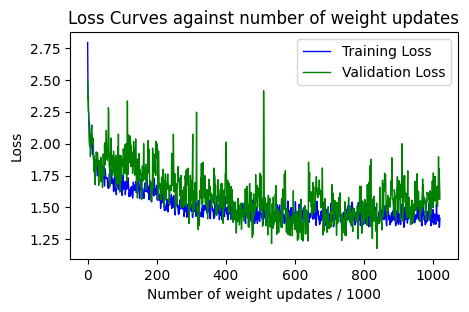

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(update_train_lst, 'b', label='Training Loss', linewidth = 1)
plt.plot(update_val_lst, 'g', label='Validation Loss', linewidth = 1)
plt.title('Loss Curves against number of weight updates')
plt.xlabel('Number of weight updates / 1000')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plotting the loss curves for every epoch

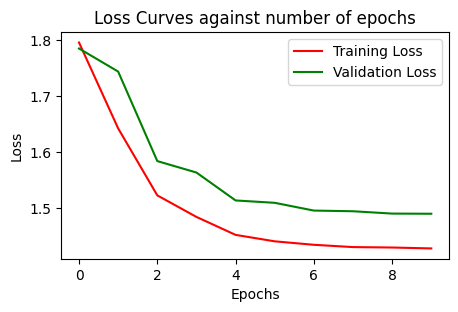

In [ ]:
epochs = range(1, 6)
plt.figure(figsize=(5,3), dpi=100)
plt.plot(epoch_train, 'r', label='Training Loss')
plt.plot(epoch_val, 'g', label='Validation Loss')
plt.title('Loss Curves against number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

####Using the model to test custom inputs

In [ ]:
def generate(model, out_len, start):

  model.eval()
  ch = [x for x in start] #Making the start into list
  pred_size = out_len - len(ch)

  for i in range(pred_size):
    char = np.array([[ch_to_int[c] for c in ch]])
    char = one_hot_encode(char, unique_n, char.shape[1], 1)
    char = np.transpose(char, (1,0,2))
    char = torch.from_numpy(char)
    char = char.to(device)
    out,_ = model(char)
    prob = nn.functional.softmax(out[-1], dim=0).data
    prob = prob.cpu().numpy()
    idx = np.where(prob == (random.choices(prob, weights = prob, k=1)))[0][0] #Picking from a Normal probability distribution of output
    ch.append(int_to_ch[idx])

  return ''.join(ch)

In [ ]:
generate(model, 500, 'It is')

'It is a few that I have been treected told Prince Andrew with a loor destriating with a letter that swaled to what he had speak. "There\'s thoughts at considerders with well asked Rostovs\' suddenly returned French at in this, natural began to such of duty shoad stood back and brotes besove, de very how general dying to retore for his setter, that not to Natasha. What a mat, but his first remain from Napolekn\'s head asking and rubred in her hunaim along the dable red. The surpress of the equater o'